# 0. Introduction

In the last exercises, you implemented different networks for image classification on the CIFAR10 Dataset.
For this exercise you will work on pixelwise segmentation (think: classification per pixel instead of per image). 
There are multiple types of segmentation, the most prominent ones are semantic segmentation and instance segmentation.
The goal of semantic segmentation is to assign to each pixel a class (e.g. car, bike), whereas the goal of instance segmentation is to assign to each pixel some object id.
This can also be combined to e.g. extract all individual cars from an image (semantic instance segmentation).

## Grading

You can get a maximum of 50 points.

| Section | Part                                 | Task                  | Points |
|---------|--------------------------------------|-----------------------|--------|
| 1       | Data Loader                          | Augmentation          | 5      |
| 2       | Conv-Pass                            | Implementation        | 10     |
| 3       | Up-sample                            | Implementation        | 5      |
| 4       | Down-sample                          | Implementation        | 5      |
| 5       | U-Net                                | Implementation        | 10     |
| 6       | Foreground/Background Segmentation   | Define U-Net instance | 5      |
|         |                                      | Same padding          | 5      |
|         |                                      | Valid padding         | 5      |
|         | Total Points                         |                       | 50     |

## General Information

**Workflow** For this assignment you need a GPU. If you have one, you can keep on working locally with this notebook. If not, we recommend to use colab. If both options do not work for you, please let us know.

**Assignment submission** You need to submit both this notebook and the model(s) you've trained. If the model is small enough you can submit it via moodle, otherwise upload it e.g. on google drive or firefox send and submit a text file with the link to it.

## How to setup Google Colab

You already know about colab from the previous exercises. Here are the most important infos again:

**Requirements** To use Colab, you must have a Google account with an associated Google Drive.

**Reminder** Ressources on colab are not guaranteed and therefore there might be times where some ressources cannot get allocated. If you're idle for 90 minutes or your connection time exceeds the maximum of 12 hours, the colab virtual machine will disconnect. This means that unsaved progress such as model parameters are lost.

**Upload the data**
You need to upload your data on the remote machine. Make sure to upload the zip and not the extracted data, this is significantly faster. There are two primary options:  
You can upload the data directly into colab (Click on the Files icon on the left side and then on upload). This is the most straightforward way, but you have to do it every time you start a new colab session.  
The second option is to use Google Drive and import the data from there into Colab. 
First, you need to upload the provided zip file (data.zip) to your Google Drive. Next, you mount your Google Drive on the remote machine. In order to do so, you can use the cell below.  
In all case you then have to execute the "extract data" cell to unpack the zip file (You might have to change the path_to_zip variable).  
Use the "verify" cell to make sure that the data is accessible.

In [1]:
import os

#### DO NOT DELETE THIS COMMENT ####
from google.colab import drive

### mount your google drive
drive.mount('/content/drive')

# add your local project folder to be able to import all utils files
path = "/content/drive/My Drive/Colab Notebooks/sose23" # change this to your local project folder
os.chdir(path)

#### DO NOT DELETE THIS COMMENT ####

KeyError: 'CLOUDSDK_CONFIG'

In [ ]:
path_to_zip = "data.zip"

In [ ]:
!unzip $path_to_zip

Archive:  data.zip
replace dsb2018/test/4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b.zarr/.zgroup? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
# verify that the data is found
import os
import glob
fls = glob.glob(os.path.join("dsb2018", "train", "*.zarr"))
print(len(fls), fls[:5])

30 ['dsb2018/train/49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc.zarr', 'dsb2018/train/0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275.zarr', 'dsb2018/train/150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f.zarr', 'dsb2018/train/14cc1424c59808274e123db51292e9dbb5b037ef3e7c767a8c45c9ac733b91bf.zarr', 'dsb2018/train/449a9c32e53a37c8a86e01c199155c8da3958b631088e10f6fe43c2119defe51.zarr']


## Install and import packages

In [ ]:
!pip uninstall albumentations -y
!pip install numpy~=1.22.4 pillow~=9.1.1 matplotlib~=3.5.2 scikit-image~=0.19.2 zarr~=2.11.3 imgaug~=0.4.0 torchsummary tensorboard~=2.9.1 mahotas~=1.4.12

# Shapely-2.0.4 imgaug-0.4.0 opencv-python-4.9.0.80 torchsummary-1.5.1 missing

In [ ]:
%matplotlib inline
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import zarr
from imgaug import augmenters as iaa
from imgaug.augmentables.heatmaps import HeatmapsOnImage
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary

from utils.label import PredictionType
from utils.train_val_test import (
    epoch_train_val_routine,
    simple_test,
)
from utils.visualize import (
    plot_image,
    plot_random_image,
    plot_history,
    show_predictions,
)


plt.rcParams['image.cmap'] = 'gist_earth'
torch.backends.cudnn.benchmark = True

# 1. Data
For this task we use a subset of the data used in the kaggle data science bowl 2018 challenge (https://www.kaggle.com/c/data-science-bowl-2018/).

## Raw Data

Example image:

![kaggle_example](https://data.broadinstitute.org/bbbc/BBBC038/BBBC038exampleimage1.png)

All images show nuclei recorded using different microscopes and lighting conditions. There are 30 images in the training set, 8 in the validation set and 16 in the test set.

Visualize the data:

Execute the next cell repeatedly to have a look at the data.
We start with the foreground/background segmentation. So the ground truth has 2 labels: Background is zero and cell is one.

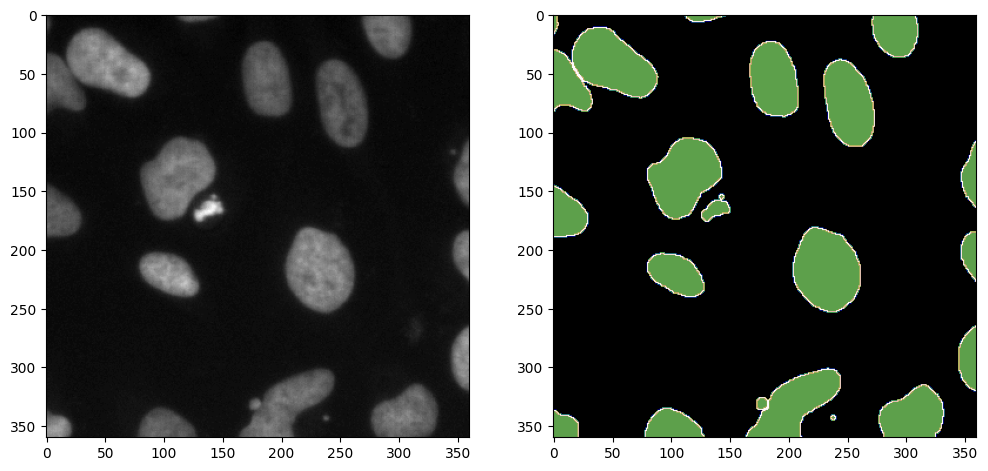

In [ ]:
# repeatedly execute this cell to get different images
plot_random_image()

## Load the data

Here we implement a custom dataset for the kaggle data.
Look at the code to briefly get an understanding what happens.

For more information, you can look here:
https://pytorch.org/docs/stable/data.html
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

### Augmentation

Especially when the size of the dataset is limited, data augmentation is essential to get good results.
Extend your data loader to augment your data during training on the fly.
Think about what kind of augmentation to use (e.g. flips, rotation, elastic).

Here, we have prepared the code to use the external data augmentation library imgaug (https://imgaug.readthedocs.io/en/latest/).

In [ ]:
class KaggleDSB_dataset(Dataset):
    """(subset of the) kaggle data science bowl 2018 dataset.
    The data is loaded from disk on the fly and in parallel using the torch dataset class.
    This enables the use of datasets that would not fit into main memory and dynamic augmentation.

    Args:
        root_dir (string):
            Directory with all the images.
        mode (string):
            train/val/test, select subset of images
        prediction_type (hpi_sose23.exercise_9.solution.utils.label.PredictionType):
            default to be "metric_learning" for this notebook
        padding_size (int):
            the number of pixels to pad on each side of the image before augmentation and cropping

    """

    def __init__(
            self,
            root_dir,
            mode,
            prediction_type,
            padding_size=None
    ):
        self.mode = mode
        self.files = glob.glob(os.path.join(root_dir, mode, "*.zarr"))
        self.prediction_type = prediction_type
        self.padding_size = padding_size
        self.define_augmentation()
        self.define_padding()

    def __len__(self):
        return len(self.files)

    def define_augmentation(self):
        """Define the augmentation pipeline for the dataset"""
        self.transform = iaa.Identity()

        ###########################################################################
        # TODO (optional): Define your augmentation pipeline.                     #
        #  Do not apply augmentation that changes the shape of the data           #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def define_padding(self):
        """Define the padding size for the dataset."""
        self.pad = None

        ###########################################################################
        # TODO: Define the 'pad' attribute.                                       #
        #  - use imgaug to pad the image with the given padding size              #
        # Hint: We do want the shape of the image to change after padding.        #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def get_filename(self, idx):
        """Get the filename of the idx-th sample

        Args:
            idx:
                The index of the sample

        Returns:
            filename (string)

        """
        return self.files[idx]

    def __getitem__(self, idx):
        fn = self.get_filename(idx)
        raw, label = self.load_sample(fn)
        raw = self.normalize(raw)

        # augment for training
        if self.padding_size is not None:
            raw = self.pad(images=raw)  # CHW -> CHW
            label = self.pad(images=label)  # CHW -> CHW

        if self.mode == "train":
            raw = np.transpose(raw, [1, 2, 0])  # CHW -> HWC
            label = np.transpose(label, [1, 2, 0])  # CHW -> HWC
            raw, label = self.augment_sample(raw, label)  # HWC -> HWC
            raw = np.transpose(raw, [2, 0, 1])  # HWC -> CHW
            label = np.transpose(label, [2, 0, 1])  # HWC -> CHW

        # put to torch tensors and return
        raw, label = torch.tensor(raw), torch.tensor(label)
        return raw, label

    def augment_sample(self, raw, label):
        """Augment a sample with the defined augmentation pipeline above.

        Args:
            raw:
                The raw image
            label:
                The label image

        Returns:
            The augmented raw and label image

        """
        # stores float label (sdt) differently than integer label (rest)
        if self.prediction_type == PredictionType.SDT:
            label = HeatmapsOnImage(label, shape=raw.shape, min_value=-1.0, max_value=1.0)
            raw, label = self.transform(image=raw, heatmaps=label)
        else:
            label = label.astype(np.int32)
            label = SegmentationMapsOnImage(label, shape=raw.shape)
            raw, label = self.transform(image=raw, segmentation_maps=label)

        label = label.get_arr()

        # some pytorch version have problems with negative indices introduced by e.g. flips: just copying fixes this
        label = label.copy()
        raw = raw.copy()

        return raw, label

    @staticmethod
    def normalize(raw):
        """Normalize the raw image to zero mean and unit variance.

        Args:
            raw:
                The raw image

        Returns:
            The normalized raw image

        """
        raw -= np.mean(raw)
        raw /= np.std(raw)
        return raw

    def load_sample(self, filename):
        """Load a sample from a zarr file depending on the prediction type.

        Args:
            filename:
                The filename of the zarr file

        Returns:
            The raw and label image

        """
        data = zarr.open(filename)
        raw = np.array(data['volumes/raw'])
        if self.prediction_type == PredictionType.TWO_CLASS:
            label = np.array(data['volumes/gt_fgbg'])
        elif self.prediction_type == PredictionType.THREE_CLASS:
            label = np.array(data['volumes/gt_threeclass'])
        elif self.prediction_type == PredictionType.AFFINITIES:
            label = np.array(data['volumes/gt_affs'])
        elif self.prediction_type == PredictionType.SDT:
            label = np.array(data['volumes/gt_tanh'])
        elif self.prediction_type == PredictionType.METRIC_LEARNING:
            label = np.array(data['volumes/gt_labels'])
        else:
            raise NotImplementedError
        label = label.astype(np.float32)
        return raw, label


### Check the data
Look at the training data to see if your dataset and data loader are working and,
if you are using augmentation, if the augmentation looks reasonable.

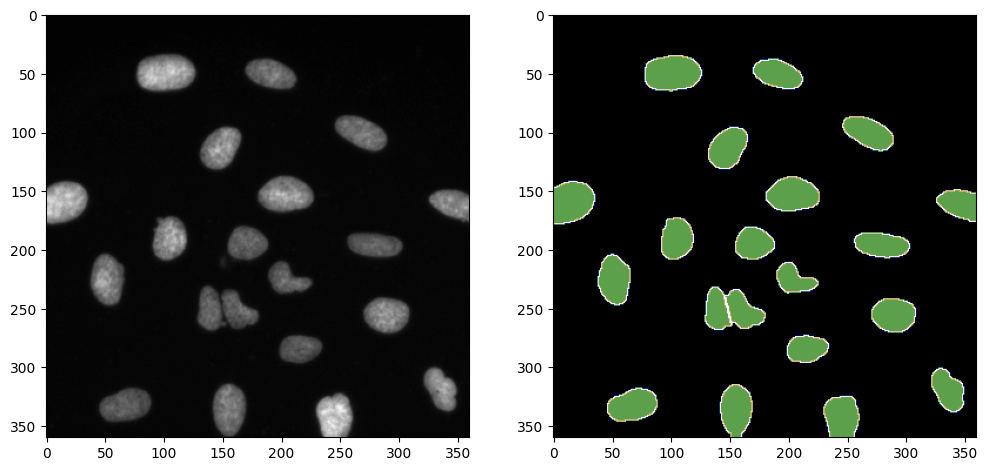

The shape of the dataset is: torch.Size([1, 360, 360])


In [ ]:
# lets look at our raw data
plot_random_image()

dataset = "dsb2018"
prediction_type = PredictionType.TWO_CLASS
num_fmaps_out = 2
dtype = torch.FloatTensor

# let's look at our data for the specific prediction type without using padding
tmp_data = KaggleDSB_dataset(dataset, mode="train", prediction_type=prediction_type)
print("The shape of the dataset is: {}".format(tmp_data[0][0].shape))


In [ ]:
# let's check our data size and make sure it is the correct shape.
assert tmp_data[0][0].shape == (1, 360, 360), "The shape of the dataset is not correct"

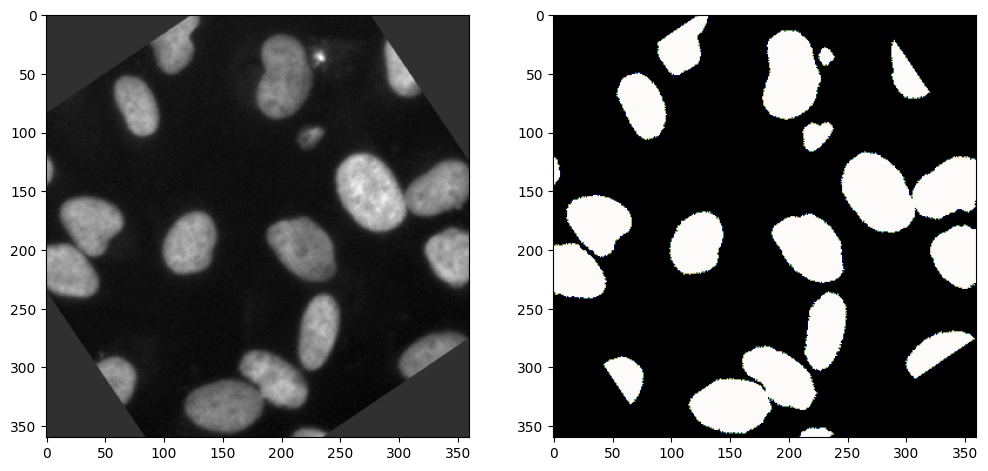

In [ ]:
# lets look at our augmented data
img_tmp, label_tmp = tmp_data[np.random.randint(0, len(tmp_data), 1)[0]]
plot_image(img_tmp, label_tmp, prediction_type=prediction_type)

Throughout the exercise we will deal with the following prediction Types. For now you will focus on the Two Class case.

In [ ]:
print([str(x) for x in PredictionType])

['PredictionType.TWO_CLASS', 'PredictionType.THREE_CLASS', 'PredictionType.SDT', 'PredictionType.AFFINITIES', 'PredictionType.METRIC_LEARNING']


# 2. U-Net

The network you will use is a so-call U-Net. Your task is to implement it and use it to segment the dataset described above.
The U-Net is a popular core architecture for segmentation and extensively used for medical and biological data.

![unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Start by reading the paper: [U-Net: Convolutional Networks for BiomedicalImage Segmentation](https://arxiv.org/pdf/1505.04597.pdf). It has been hugely influential in the field and it is very concise and understandable.
We recommend asking your colleagues on the moodle forums with respect to unclear aspects of the architecture.
(If that does not solve it, there are also a number of tutorials online).

## Implementation

Your main task is to implement a U-Net yourselves step-by-step. 
(Disclaimer: We are aware that there are a number of implementations out there, but we **strongly recommend** to not look at them before trying it yourselves, this is a very fundamental exercise, and the knowledge you gain will be very helpful to you if you try to implement other architectures, and you learn significantly more by trying it yourselves than by looking at other people's code.
The implementation is not completely straight forward. If you are stuck, ask in the forum or check out one of the tutorials online.
Feel free to look at the implementations **after** you have a working version and get results on the data.
It might be a helpful exercise to check what they maybe have done better and what you maybe have done better.
Yet there is no need to change your implementation, there are no extra points for the most elegant or efficient solution).

Be aware: Do not re-implement torch.nn modules. You are free to use them!

**Padding:** Both, valid or same padding should work for your convolutions.

**Upsampling**: Pytorch has modules for upsampling and transposed convolutions. Make sure both work.

### Convolutional Pass

We start by implementing a convolutional pass. This is a series of convolutions, each followed by an activation function.

The convolutional pass should be able to handle both, 'VALID' and 'SAME' padding.
You can see where the convolutional pass is used in the U-Net architecture in the image below.

![conv_pass](./images/u-net-architecture-conv.png)

In [ ]:
class ConvPass(torch.nn.Module):
    """Convolutional pass of a U-Net."""

    # Do not change the constructor signature.
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_sizes,
            padding,
            activation
    ):
        """Constructor of a convolutional pass.
        The pass consists of a series of convolutions, each followed by an activation function.

        Args:
            in_channels:
                Number of input channels
            out_channels:
                Number of output channels
            kernel_sizes:
                List of kernel sizes
            padding:
                Padding type, either 'VALID' or 'SAME'
            activation:
                Activation function, e.g. 'ReLU'
        """

        super(ConvPass, self).__init__()

        if activation is not None:
            activation = getattr(torch.nn, activation)

        ###########################################################################
        # TODO: Implement the ConvPass constructor.                               #
        # hint: You can use any (or no)  attribute that you deem usefully.        #
        # Remember to support both, 'VALID' and 'SAME' padding.                   #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

       

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x):
        """Forward pass of the convolutional pass.

        Args:
            x:
                Input tensor

        Returns:
            Output tensor after applying the convolutional pass

        """
        i = torch.nn.Identity()
        c = i(x)
        ###########################################################################
        # TODO: Implement the ConvPass forward pass.                              #
        # hint: This is not a single convolution operation!                       #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return c

### Test your convolutional pass

You can check if your convolutional pass works as expected with the following test.

In [ ]:
input = torch.zeros((1, 3, 10, 10))
kernels = [[3, 3], [3, 3]]
activation = "ReLU"

c_v = ConvPass(3, 3, kernels, "VALID", activation)
c_s = ConvPass(3, 3, kernels, "SAME", activation)

output_v = c_v(input)
output_s = c_s(input)

print("Output shape with VALID padding: ", output_v.shape)
print("Output shape with SAME padding: ", output_s.shape)

Output shape with VALID padding:  torch.Size([1, 3, 6, 6])
Output shape with SAME padding:  torch.Size([1, 3, 10, 10])


### Downsample

Next, we implement a downsampling layer. This layer is used in the U-Net to reduce the spatial dimensions of the input tensor.

There is no harm in using the torch library for this task.

You can see where the downsample pass is used in the U-Net architecture in the image below.

![conv_pass](./images/u-net-architecture-down.png)

In [ ]:
class Downsample(torch.nn.Module):
    """Downsampling layer of a U-Net."""

    def __init__(
            self,
            downsample_factor
    ):
        """Constructor of a downsampling layer.

        Args:
            downsample_factor:
                Factor by which to downsample the input tensor.

        """
        super(Downsample, self).__init__()
        self.dims = len(downsample_factor)
        self.downsample_factor = downsample_factor

        ###########################################################################
        # TODO: Implement the downsample constructor.                             #
        # hint: You can use/define any (or no) attribute that you deem usefully.  #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x):
        """Forward pass of the downsampling layer.

        Args:
            x:
                Input tensor

        Returns:
            Output tensor after applying the downsampling layer
        """
        i = torch.nn.Identity()
        d = i(x)
        self.assert_downsample_factor(x)

        ###########################################################################
        # TODO: Implement the downsample forward pass.                            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return d

    def assert_downsample_factor(self, x):
        """Assert if the downsample factor is compatible with the input tensor.

        Args:
            x:
                Input tensor

        Returns:
            True if the downsample factor is compatible with the input tensor, raises RuntimeError otherwise
        """
        for d in range(1, self.dims + 1):
            if x.size()[-d] % self.downsample_factor[-d] != 0:
                raise RuntimeError(
                    "Can not downsample shape %s with factor %s, mismatch in spatial dimension %d" % (
                        x.size(),
                        self.downsample_factor,
                        self.dims - d)
                )
        return True

### Test your downsample layer

You can check if your downsample layer works as expected with the following test.

In [ ]:
input = torch.zeros((1, 3, 20, 20))
downsample_factor1 = [2, 2]
downsample_factor2 = [5, 10]

d1 = Downsample(downsample_factor1)
d2 = Downsample(downsample_factor2)

output1 = d1(input)
output2 = d2(input)

print("Output shape with downsample factor [2, 2]: ", output1.shape)
print("Output shape with downsample factor [5, 10]: ", output2.shape)

Output shape with downsample factor [2, 2]:  torch.Size([1, 3, 10, 10])
Output shape with downsample factor [5, 10]:  torch.Size([1, 3, 4, 2])


#### Upsample

Next, we implement an upsampling layer. This layer is used in the U-Net to increase the spatial dimensions of the input tensor.

There is two common ways to upsample a tensor:
1. Nearest neighbor interpolation
2. Transposed convolution

Your task is to implement both methods.

Again, there is no harm in using the torch library for this task.

You can see where the upsample pass is used in the U-Net architecture in the image below.

![conv_pass](./images/u-net-architecture-up.png)

In [ ]:
class Upsample(torch.nn.Module):
    """Class that implements an upsampling layer."""

    def __init__(
            self,
            scale_factor,
            mode,
            in_channels,
            out_channels,
    ):
        """Constructor of an upsampling layer.

        Args:
            scale_factor:
                Factor by which to upsample the input tensor
            mode:
                Upsample mode, either 'nearest' or 'transpose_conv'
            in_channels:
                Number of input channels
            out_channels:
                Number of output channels

        """
        super(Upsample, self).__init__()

        self.dims = len(scale_factor)

        #############################################################################
        # TODO: Construct your Upsample object                                      #
        #  - implement both, nearest neighbor and transposed convolution upsampling #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def center_crop(self, x, shape):
        """Center-crop x to match spatial dimensions given by shape.

        Args:
            x:
                The input tensor.
            shape:
                The target shape.

        Returns:
            The center-cropped tensor.

        """

        x_target_size = x.size()[:-self.dims] + shape

        offset = tuple(
            (a - b) // 2
            for a, b in zip(x.size(), x_target_size))

        slices = tuple(
            slice(o, o + s)
            for o, s in zip(offset, x_target_size))

        return x[slices]

    def forward(self, f_left, g_out):
        """Forward pass.

        Args:
            f_left:
                Input tensor from the left branch
            g_out:
                Input tensor from the previous layer

        Returns:
            Concatenated cropped f_left with upsampled cropped g_out

        """
        i = torch.nn.Identity()
        f_right = i(g_out)
        ###########################################################################
        # TODO: Upsample forward pass                                             #
        # hint: You can use/define any (or no) attribute that you deem usefully.  #
        #       You can further define any function that you deem usefully.       #
        #       You should consider using the center_crop function above.         #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return f_right

### Test your upsample layer

In [ ]:
scale_factor = [2, 2]
input = torch.zeros((1, 3, 10, 10))

f_left = torch.ones((1, 2, 20, 20)) * 2

# check size
u1 = Upsample(scale_factor, 'transpose_conv', 3, 2)
u2 = Upsample(scale_factor, 'nearest', 3, 2)

output1 = u1(f_left, input)
output2 = u1(f_left, input)


print("Output shape with transposed convolution: ", output1.shape)
print("Output shape with nearest neighbor: ", output2.shape)

Output shape with transposed convolution:  torch.Size([1, 4, 20, 20])
Output shape with nearest neighbor:  torch.Size([1, 4, 20, 20])


### UNet

It is time to assemble the U-Net. The U-Net consists of a series of convolutional passes, downsampling layers, and upsampling layers.



In [ ]:
class UNet(torch.nn.Module):
    """UNet class."""

    def __init__(
            self,
            in_channels,
            num_fmaps,
            fmap_inc_factors,
            downsample_factors,
            kernel_size_down,
            kernel_size_up,
            activation,
            padding,
            num_fmaps_out,
            constant_upsample
    ):
        """Unet constructor.

        Create a U-Net::

            f_in --> f_left --------------------------->> f_right--> f_out
                        |                                   ^
                        v                                   |
                     g_in --> g_left ------->> g_right --> g_out
                                 |               ^
                                 v               |
                                       ...

        where each ``-->`` is a convolution pass, each `-->>` a crop, and down
        and up arrows are max-pooling and transposed convolutions,
        respectively.

        The U-Net expects 2D tensors shaped like::

            ``(batch=1, channels, height, width)``.

        This U-Net performs only "valid" convolutions, i.e., sizes of the
        feature maps decrease after each convolution.

        Args:

            in_channels:
                The number of input channels.
            num_fmaps:
                The number of feature maps in the first layer. This is also the
                number of output feature maps. Stored in the ``channels``
                dimension.
            fmap_inc_factors:
                By how much to multiply the number of feature maps between
                layers. If layer 0 has ``k`` feature maps, layer ``l`` will
                have ``k*fmap_inc_factor**l``.
            downsample_factors:
                List of tuples ``(y, x)`` to use to down- and up-sample the
                feature maps between layers.
            kernel_size_down:
                List of lists of kernel sizes. The number of sizes in a list
                determines the number of convolutional layers in the
                corresponding level of the build on the left side. Kernel sizes
                can be given as tuples or integer.
            kernel_size_up:
                List of lists of kernel sizes. The number of sizes in a list
                determines the number of convolutional layers in the
                corresponding level of the build on the right side. Within one
                of the lists going from left to right. Kernel sizes can be
                given as tuples or integer.
            activation:
                Which activation to use after a convolution. Accepts the name
                of any tensorflow activation function (e.g., ``ReLU`` for
                ``torch.nn.ReLU``).
            constant_upsample:
                If set to true, perform a constant upsampling instead of a
                transposed convolution in the upsampling layers.

        """
        super(UNet, self).__init__()

        self.num_levels = len(downsample_factors) + 1
        self.in_channels = in_channels
        self.out_channels = num_fmaps_out if num_fmaps_out else num_fmaps
        self.mode = 'nearest' if constant_upsample else 'transpose_conv'
        self.kernel_size_down = kernel_size_down
        self.kernel_size_up = kernel_size_up
        self.downsample_factors = downsample_factors

        self.l_conv = None  # you need to define this as nn.ModuleList([])
        self.l_down = None  # you need to define this as nn.ModuleList([])
        self.r_up = None  # you need to define this as nn.ModuleList([])
        self.r_conv = None  # you need to define this as nn.ModuleList([])
        ########################################################################
        # TODO: Unet                                                           #
        # - Implement your Unet class here                                     #
        # - the l_conv, l_down, l_up and l_out attributes should gather        #
        #   the respective nn.modules of the U-Net as a nn.ModuleList!         #
        # - l_conv should contain the convolutional passes of the left branch  #
        # - l_down should contain the downsample layers of the left branch     #
        # - r_up should contain the upsample layers of the right branch        #
        # - r_conv should contain the convolutional passes of the right branch #
        # - (later) Add a function to compute its receptive field              #
        # - note:                                                              #
        #   - you can define and use any additional attribute that             #
        #     you deem usefully.                                               #
        #   - this class makes use of Upsample, Downsample and ConvPass        #
        #     objects so implement the classes first!                          #
        #   - do not force the output of this UNET to any task                 #
        #     specific putput dimension! (e.g. convolut to one output channel) #
        #   - do not hardcode the number of levels!                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
      

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        self.weights_init()

    def weights_init(self):
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0.01)

        if isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0.01)


    def forward(self, x):
        """Forward pass through the network."

        Args:
            x:
                Input tensor of shape (b, c, y, x).

        Returns:
            The feature.

        """
        y = None
        ########################################################################
        # TODO: Unet forward pass                                              #
        # - Implement your Unet forward pass                                   #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return y

# 3. Foreground Segmentation with two paddings
Define your model for foreground/background segmentation and print out your network summary. This also serves as a check if your network is built correctly.

In [ ]:
unet_padding_same = torch.nn.Identity()
##########################################################################
# TODO: unet with same padding                                           #
# - now define your unet object                                          #
# - your unet should use:                                                #
#   - 1 input channel                                                    #
#   - 6 feature maps in the first layer                                  #
#   - 6 feature maps in the last layer                                   #
#   - a feature map increase factor of 2                                 #
#   - 4 downsample steps of kernel size 2x2                              #
#   - 'ReLU' activation                                                  #
#   - 'same' padding                                                     #
#   - no constant upsampling                                             #
#   - 2 convolutions per UNET Upsampling block with kernel size of 3x3   #
#   - 2 convolutions per UNET Downsampling block with kernel size of 3x3 #
##########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

unet_padding_valid = torch.nn.Identity()
##########################################################################
# TODO: unet with valid padding                                          #
# - your unet should use:                                                #
#   - 1 input channel                                                    #
#   - 32 feature maps in the first layer                                 #
#   - 32 feature maps in the last layer                                  #
#   - a feature map increase factor of 2                                 #
#   - 3 downsample steps of kernel size 2x2                              #
#   - 'ReLU' activation                                                  #
#   - 'valid' padding                                                    #
#   - no constant upsampling                                             #
#   - 2 convolutions per UNET Upsampling block with kernel size of 3x3   #
#   - 2 convolutions per UNET Downsampling block with kernel size of 3x3 #
##########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

task_head_same = torch.nn.Identity()
task_head_valid = torch.nn.Identity()

########################################################################
# TODO:                                                                #
# - Implement the last 2D convolution layer to get to your desired     #
#   output shape for both of your networks                             #
# - use a kernel size of 1x1, and no padding                           #
# - choose the right number of output channels for the                 #
#   TWO_CLASS classification problem                                   #
#   hint: Don't forget the bias                                        #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

net_same = torch.nn.Sequential(
    unet_padding_same,
    task_head_same
)

net_valid = torch.nn.Sequential(
    unet_padding_valid,
    task_head_valid
)

In [ ]:
# print network layers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_same = net_same.to(device)
net_valid = net_valid.to(device)

## Prepare the datasets for training. Choose the correct padding for your network objects.

In [ ]:
# make datasets
dataset = "dsb2018"

padding_size_same = None
padding_size_valid = None
########################################################################
# TODO:                                                                #
# - choose the correct padding here.                                   #
# - hint: the dimension of the raw data can be inspected above.        #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

data_train_same = KaggleDSB_dataset(
    dataset, "train", prediction_type=prediction_type, padding_size=padding_size_same)
data_val_same = KaggleDSB_dataset(
    dataset, "val", prediction_type=prediction_type, padding_size=padding_size_same)
data_test_same = KaggleDSB_dataset(
    dataset, "test", prediction_type=prediction_type, padding_size=padding_size_same)

data_train_valid = KaggleDSB_dataset(
    dataset, "train", prediction_type=prediction_type, padding_size=padding_size_valid)
data_val_valid = KaggleDSB_dataset(
    dataset, "val", prediction_type=prediction_type, padding_size=padding_size_valid)
data_test_valid = KaggleDSB_dataset(
    dataset, "test", prediction_type=prediction_type, padding_size=padding_size_valid)

# look at what the dataset returns
print('Train set padding same size: {}'.format(len(data_train_same)))
print('Validation set padding same size: {}'.format(len(data_val_same)))
print('Test set padding same size: {}'.format(len(data_test_same)))
data_shape_same = data_train_same[0][0].shape
print('Data dimension after your same padding: {}'.format(data_shape_same))

print("##############################################")

# look at what the dataset returns
print('Train set padding valid size: {}'.format(len(data_train_valid)))
print('Validation set padding valid size: {}'.format(len(data_val_valid)))
print('Test set size: {}'.format(len(data_test_valid)))
data_shape_valid = data_train_valid[0][0].shape
print('Data dimension after your valid padding: {}'.format(data_shape_valid))


In [ ]:
# Let's check our same-padding network
try:
    summary(net_same, data_shape_same)  # funfact: torchsummary function summary has an implementation error when trying to summarize an Identity-Network
except AttributeError:
    pass

In [ ]:
# Let's check our valid-padding network
try:
    summary(net_valid, data_shape_valid)
except AttributeError:
    pass

## prepare the dataloader for training

In [ ]:
# make dataloaders
batch_size = 4
train_loader_same = DataLoader(data_train_same, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader_same = DataLoader(data_val_same, batch_size=1, pin_memory=True)
test_loader_same = DataLoader(data_test_same, batch_size=1)

train_loader_valid = DataLoader(data_train_valid, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader_valid = DataLoader(data_val_valid, batch_size=1, pin_memory=True)
test_loader_valid = DataLoader(data_test_valid, batch_size=1)

## train your network
In the training process of semantic segmentation scenario, we usally will record two basic criteria, loss and pixel accuracy.
The loss function we use here is the Binary Cross Entropy with the sigmoid function before it.
The pixel accuracy, or accuracy for short, refers to the percent of pixels in the image which were correctly classified.

In [ ]:
net = net_same  # change me to valid if you want. Do you notice a difference in performance?
train_loader = train_loader_same # change me to valid if you want.
val_loader = val_loader_same  # change me to valid if you want.
test_loader = test_loader_same  # change me to valid if you want.

# now it is time to train the network
num_epochs = 100
net, history, optimizer = epoch_train_val_routine(
    net, 
    num_epochs,
    learning_rate=5e-4,
    train_loader=train_loader,
    val_loader=val_loader, 
    start_epoch=0, 
    dtype=dtype
)

In [ ]:
# plot loss and accuracy
if history is not None:
    plot_history(history)

## Test and evaluate our model

Accuracy: 0.982


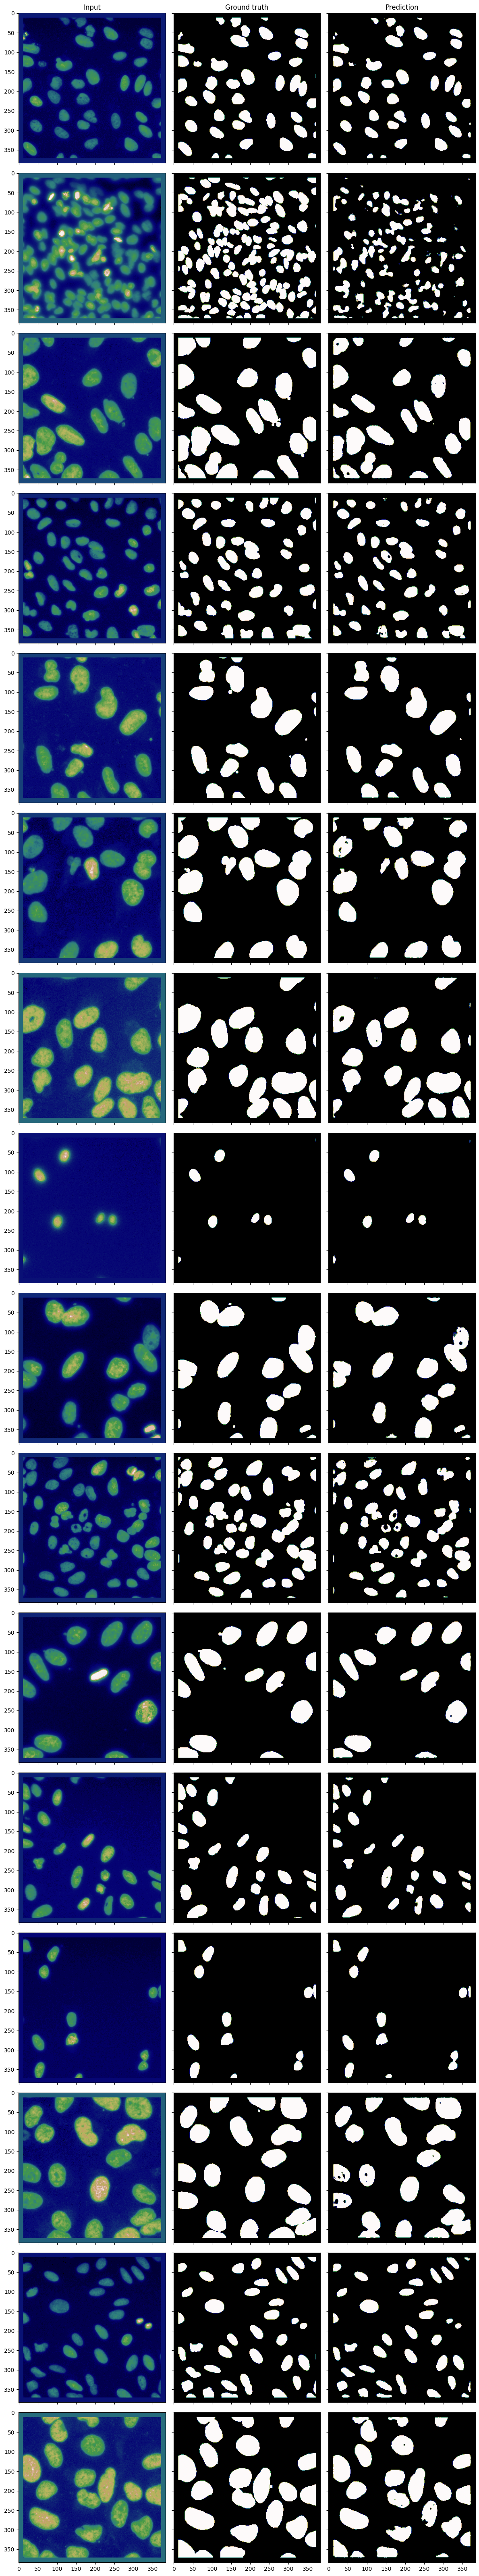

In [ ]:
# plot predicted results for test data
activation_two_class = torch.nn.Identity()
########################################################################
# TODO: Two Class Unet activation                                      #
# - Choose the right activation for your two class unet                #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################
images, labels, predictions, mean_accuracy = simple_test(net, test_loader, activation_two_class, device)
print('Accuracy: {:.3f}'.format(mean_accuracy))

show_predictions(images, labels, predictions)

The training of the networks depend on many hyperparameters such as
- network architecture: #layers, #fmaps
- batch size, learning rate
- number and distribution of the training samples

You can play and see how these settings influence the learning curve.

![image](https://drive.google.com/uc?export=view&id=18KqN2SHcjVk0EhQtG7JI8SerbpMtBldZ)